## Utility of Membership Inference Private models vs. Differentially Private models

In this notebook, we evaluate the utility of some classification models to show that membership inference privacy often results in no loss of utility for realistic models and values for the privacy parameter $\mu$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
import os
os.chdir("..")

In [3]:
## Privacy compuation functions
from gmip.utils import calc_privacy_lvl, calc_dp_privacy_lvl, get_fn, compute_tau

import matplotlib.pyplot as plt
import numpy as np

## 1. Visualize required $\mu$ for the noise levels (see Table 5 in the Appendix of the paper)

In [6]:
# arrange values from 0.4 to 50 equally in log-space
mus = np.exp(np.linspace(np.log(0.4), np.log(50), 20))

In [7]:
## Experimental parameters for the datasets:
params = {
    "CIFAR10": dict(C=500.0, N=48000, T=1200, batch_size=400, K=650, d=650, epochs=10), # 10 epoch with 120 batchs and batch size 400
    "purchase": dict(C=2000.0, N=69*795, T=3*69, batch_size=795, K=2580, d=2580, epochs=3), # We have 69 batches with batch size 795 each in one epoch, train 3 epochs
    "adult": dict(C=800.0, N=43000, T=43*20, batch_size=1000, K=1026, d=1026, epochs=20) # 20 epochs with 43 batches and batch size 1000
}


In [8]:
## What is the Membership Inference privacy level that we get using these parameters without additional noise (tau=0.0)?
for key, val_dict in params.items():
    print(f"Privacy guarantee without noise on dataset {key}: mu=", calc_privacy_lvl(val_dict["C"], 0.0, val_dict["T"], val_dict["batch_size"], val_dict["N"], val_dict["d"], val_dict["K"]))

Privacy guarantee without noise on dataset CIFAR10: mu= 0.7865955046430421
Privacy guarantee without noise on dataset purchase: mu= 1.4470370595554225
Privacy guarantee without noise on dataset adult: mu= 1.1921696789742704


### Compute required noise levels (Table 5, Appendix)

In [9]:
noise_dp = {}
noise_mip = {}
for key, val_dict in params.items():
    noise_dp[key] = []
    noise_mip[key] = []
    for mu_use in mus:
        noise_dp[key].append(compute_tau(mu_use, val_dict["C"], val_dict["K"], val_dict["d"], val_dict["N"], val_dict["T"], val_dict["batch_size"], dp=True, init_value=1.0))
        noise_mip[key].append(compute_tau(mu_use, val_dict["C"], val_dict["K"], val_dict["d"], val_dict["N"], val_dict["T"], val_dict["batch_size"], dp=False, init_value=1.0))

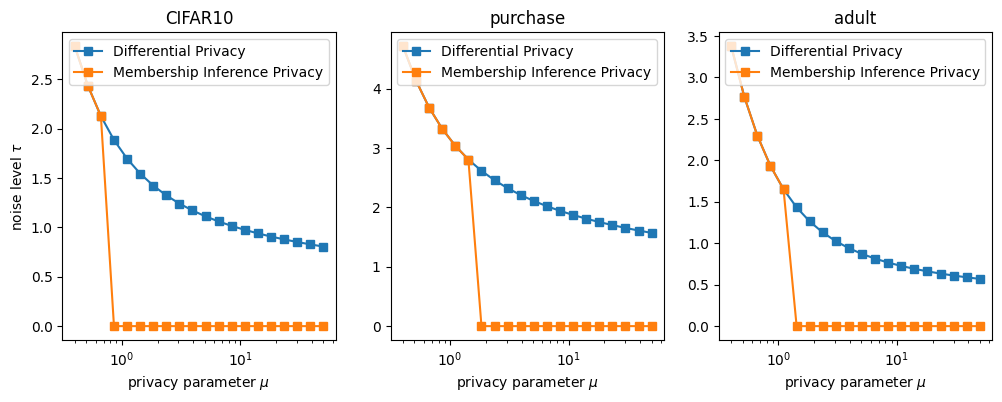

In [10]:
f, ax_list = plt.subplots(1,3 )
for i, key in enumerate(params.keys()):
    ax = ax_list[i]
    ax.set_title(key)
    ax.semilogx(mus, noise_dp[key], "-s", label="Differential Privacy")
    ax.semilogx(mus, noise_mip[key], "-s", label="Membership Inference Privacy")
    ax.legend()
    ax.set_xlabel(r"privacy parameter $\mu$")

ax_list[0].set_ylabel(r"noise level $\tau$")
f.set_size_inches(12, 4)

## 2. Load trained models and plot the accuracies

To run this part of the script, the corresponding models first need to be trained. To do so, please run the script ```scripts/train_scripts/train_models_util.sh <dataset>``` with the dataset to use as only argument. Train the models this way for datasets "adult", "purchase", and "cifar10".

In [19]:
import torch
def load_utilities(model_path, params, dataset):
    """ Load model files and return utility matrices (dp_accuray, mip_accuracy) with one line per run. """
    n_runs = 5
    n_mus = 20
    dp_accs = np.zeros((n_mus, n_runs))
    mip_accs = np.zeros((n_mus, n_runs))
    usepar = params[dataset]
    if dataset == "CIFAR10":
        suffix = "_resnet56"
    else:
        suffix = ""
        
    for i in range(n_mus):
        for run in range(n_runs):
            if dataset == "CIFAR10":
                res_dict = torch.load(f"{model_path}/{dataset}_C{int(usepar['C'])}_tauDP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
                torch.save(res_dict, f"{model_path}/{dataset}_C{usepar['C']}_tauDP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
                
                res_dict = torch.load(f"{model_path}/{dataset}_C{int(usepar['C'])}_tauMIP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
                torch.save(res_dict, f"{model_path}/{dataset}_C{usepar['C']}_tauMIP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
                
            res_dict = torch.load(f"{model_path}/{dataset}_C{usepar['C']}_tauDP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
            dp_accs[i, run] = res_dict["final_acc"]
            res_dict = torch.load(f"{model_path}/{dataset}_C{usepar['C']}_tauMIP{i}_batch{usepar['batch_size']}_ep{usepar['epochs']}{suffix}_{run}.pt")
            mip_accs[i, run] = res_dict["final_acc"]
    return dp_accs, mip_accs

def plot_utilities(dp_accs, mip_accs, dataset):
    f, ax = plt.subplots()
    colors = ["tab:blue", "tab:green"]
    param_name = ["Diff. Privacy (DP)", "Mem. Inf. Privacy (MIP)"]
    use_slice = slice(0,20)
    mus_use = mus[use_slice]
    param_data = [dp_accs[use_slice], mip_accs[use_slice]]
    for setup_use, data_mat, color_use in zip(param_name, param_data, colors):
        mean_rnd = np.mean(data_mat, axis=1)
        mean_rnd_std = np.std(data_mat, axis=1) # Standard error
        plt.semilogx(mus_use, mean_rnd, "-s", label = setup_use, color=color_use, markersize=3)  
        plt.fill_between(mus_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.3)


    #plt.plot(fs,fs, "--k")#

    #plt.plot(fs,analtical_tpr(fs,1.13), color="tab:blue", label = f"analytical ($\mu=1.13$)")
    plt.xlabel(r"privacy ($\mu$)")
    plt.ylabel("accuracy (\%)")
    plt.legend()
    plt.grid()
    plt.title(dataset)
    plt.gcf().set_size_inches(4.0,3.0)
    plt.tight_layout()

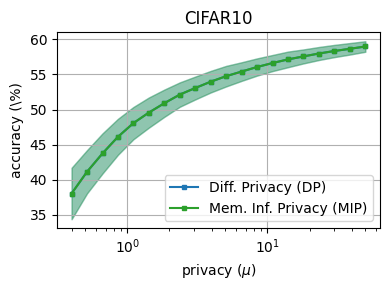

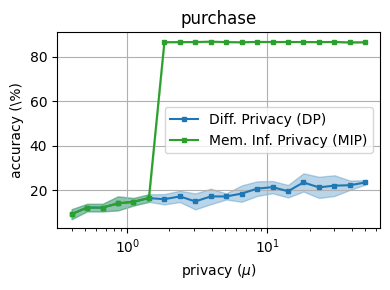

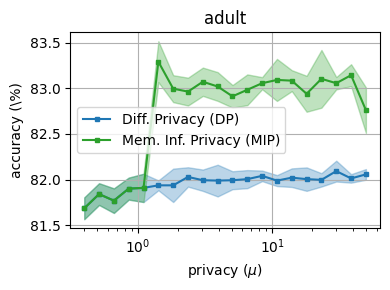

In [20]:
for k in params.keys():
    dp_acc, mip_acc = load_utilities("models", params, k)
    plot_utilities(dp_acc, mip_acc, k)